<a href="https://colab.research.google.com/github/anders-graffe/experimentos/blob/main/%5BChurn_Model%5D_Predicci%C3%B3n_de_bajas_de_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Métricas
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Gráficos
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

#Preprocesamiento
from sklearn.preprocessing import StandardScaler


# **Datos**
El dataset en cuestión cuenta de los siguientes campos:


*  **user_id:** identificador unívoco anonimizado del usuario.
*  **install_time:** indica la fecha y horario en que se registró la instalación (UTC).
*  **platform:** plataforma del usuario, puede ser: Android o iOS.
*  **country_region:**sería el equivalente a provincia.
*  **city:** ciudad.
*  **gender:** género del usuario, puede ser: hombre o mujer.
*  **min_age_range:** cota inferior del rango de edad.
*  **max_age_range:** cota superior del rango de edad.
*  **event_1:**cantidad de eventos de un tipo anonimizado.
*  **event_2:** cantidad de eventos de un tipo anonimizado.
*  **event_3:** cantidad de eventos de un tipo anonimizado.
*  **event_4:** cantidad de eventos de un tipo anonimizado.
*  **event_5:** cantidad de eventos de un tipo anonimizado.
*  **target_churn_indicator:** Si es 1 significa que no jugó el día siguiente, en cambio, si es 0 significa que jugó.

In [30]:
df = pd.read_csv('https://raw.githubusercontent.com/anders-graffe/experimentos/main/churn_app.csv')
df = df.set_index('user_id') #Setear index
df['install_time']= pd.to_datetime(df['install_time']) #Cambiar a tipo fecha

df.head(3)

,install_time,platform,country_region,city,gender,min_age_range,max_age_range,event_1,event_2,event_3,event_4,event_5,target_churn_indicator
user_id,,,,,,,,,,,,,
2ba6f357,2018-07-04 19:24:24,Android,Santa Cruz,Río Gallegos,male,13,17,1,2,0,1,1,0
3cb936c1,2018-06-30 13:41:29,Android,Corrientes,Corrientes,male,13,17,0,7,0,3,0,1
17d88bbc,2018-06-30 16:02:30,Android,Cordoba,Villa Carlos Paz,female,18,20,2,1,0,2,2,1


### **Nuevas variables**

---





> ##### **Variables discretizadas**



In [31]:
df['day_of_week']= df['install_time'].dt.day_name()
df['age_range'] = df.apply(lambda row: '13-18' if row['min_age_range'] >= 0 and row['max_age_range'] <= 18 else '18-20', axis=1)
#df['hour_range'] = pd.cut(df['install_time'].dt.hour, bins=[0, 4, 8, 12, 16, 20, 24], labels=['0-4 hs', '4-8 hs', '8-12 hs', '12-16 hs','16-20 hs','20-24 hs'])
df['hour'] = df['install_time'].dt.hour
df2 = df.drop(['min_age_range',	'max_age_range','city','country_region'], axis=1)

df2.head(3)

,install_time,platform,gender,event_1,event_2,event_3,event_4,event_5,target_churn_indicator,day_of_week,age_range,hour
user_id,,,,,,,,,,,,
2ba6f357,2018-07-04 19:24:24,Android,male,1,2,0,1,1,0,Wednesday,13-18,19
3cb936c1,2018-06-30 13:41:29,Android,male,0,7,0,3,0,1,Saturday,13-18,13
17d88bbc,2018-06-30 16:02:30,Android,female,2,1,0,2,2,1,Saturday,18-20,16



> ##### **Escalado de variables númericas**

In [32]:
df_numeric = df2[['event_1', 'event_2', 'event_3', 'event_4', 'event_5']].copy()
df_index = df2.index
df2 = df2.drop(columns=df_numeric.columns)

scaler = StandardScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Reiniciar los índices
df_numeric_scaled.index = df_index

# Concatenar el DataFrame original con las variables escaladas
df2 = pd.concat([df2, df_numeric_scaled], axis=1)

> ##### **Tablas de contigencia y Matriz de correlación**

In [33]:
categoricas = df2.select_dtypes(include=['object','category'])


for variable in categoricas:
    # Crear la tabla de contingencia
    contingency_table = pd.crosstab(df2[variable], df2['target_churn_indicator'], margins=True, margins_name='Total')

    # Calcular el ratio de churn
    contingency_table['Churn Ratio'] = contingency_table[1] / contingency_table['Total']

    # Mostrar la tabla de contingencia y el ratio de churn
    print(f"\nTabla de Contingencia para '{variable}':")
    print(contingency_table)




Tabla de Contingencia para 'platform':
target_churn_indicator     0      1  Total  Churn Ratio
platform                                               
Android                 8894  10618  19512     0.544178
iOS                      292    196    488     0.401639
Total                   9186  10814  20000     0.540700

Tabla de Contingencia para 'gender':
target_churn_indicator     0      1  Total  Churn Ratio
gender                                                 
female                  5116   5719  10835     0.527826
male                    3979   5013   8992     0.557496
unknown                   91     82    173     0.473988
Total                   9186  10814  20000     0.540700

Tabla de Contingencia para 'day_of_week':
target_churn_indicator     0      1  Total  Churn Ratio
day_of_week                                            
Friday                  1254   1138   2392     0.475753
Monday                  1311   1158   2469     0.469016
Saturday                1335   3695   5

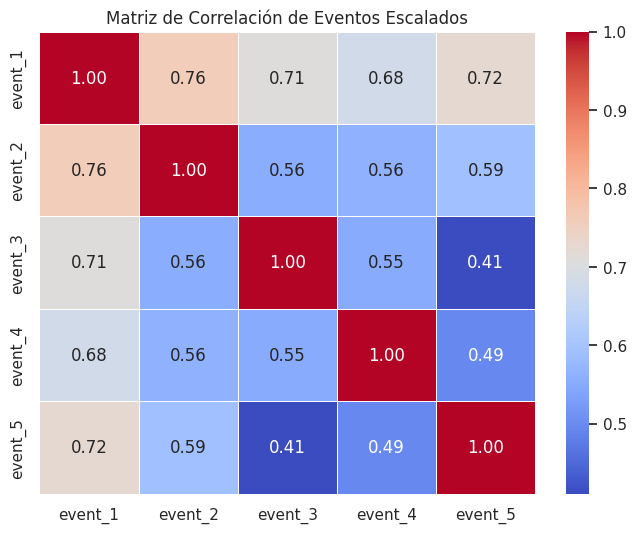

In [34]:
df_numeric_scaled = df2[['event_1', 'event_2', 'event_3', 'event_4', 'event_5']]
corr_scaled = df_numeric_scaled.corr() # Calcular la matriz de correlación

# Configurar el estilo de la matriz de correlación
sns.set(style="whitegrid")

# Crear una figura con un solo subgráfico
plt.figure(figsize=(8, 6))

# Matriz de correlación después de escalar
sns.heatmap(corr_scaled, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación de Eventos Escalados")
plt.show()


> ##### **Variables dummies**

In [35]:
for columna in categoricas:
    df_dummies = pd.get_dummies(df2[columna], prefix=columna)
    df2 = pd.concat([df2, df_dummies], axis=1)

df2 = df2.drop(categoricas, axis=1) # Se eliminan las columnas originales
df2= df2[df2['install_time'] > '2018-06-30 23:59:59'] # Excluimos 30-jul ya que presentaba comportamiento atipico
df2.head(3)

,install_time,target_churn_indicator,hour,event_1,event_2,event_3,event_4,event_5,platform_Android,platform_iOS,...,gender_unknown,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,age_range_13-18,age_range_18-20
user_id,,,,,,,,,,,,,,,,,,,,,
2ba6f357,2018-07-04 19:24:24,0,19,-0.669710,-0.624034,-0.422947,-0.792063,-0.766059,1,0,...,0,0,0,0,0,0,0,1,1,0
7baa10b6,2018-07-02 21:08:33,0,21,-0.459633,-0.475541,-0.422947,-0.555004,0.121482,1,0,...,0,0,1,0,0,0,0,0,1,0
120d379,2018-07-07 04:18:47,0,4,-0.302075,-0.252801,-0.422947,-0.555004,-0.322288,1,0,...,0,0,0,1,0,0,0,0,1,0


### **Dataset final (train y test)**

---


In [36]:
df_final = df2.drop('install_time', axis=1)
X = df_final.drop('target_churn_indicator', axis=1)
y = df_final['target_churn_indicator']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> ##### **Regresión logística**

In [48]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_logistic = logistic_model.predict(X_test)

# Evaluar el modelo
print("Accuracy Score:", accuracy_score(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))

Accuracy Score: 0.6999152302910426
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.60      0.67      1819
           1       0.66      0.81      0.72      1720

    accuracy                           0.70      3539
   macro avg       0.71      0.70      0.70      3539
weighted avg       0.71      0.70      0.70      3539

Confusion Matrix:
 [[1088  731]
 [ 331 1389]]


In [50]:
# Coeficientes y odds ratios
coeficientes = logistic_model.coef_[0]
odds_ratios = np.exp(coeficientes)

# Resultados
resultados = pd.DataFrame({'Variable': X_train.columns, 'Coeficiente': coeficientes, 'Odds Ratio': odds_ratios})
resultados = resultados.sort_values(by='Odds Ratio', ascending=False)
resultados


,Variable,Coeficiente,Odds Ratio
5,event_5,0.139558,1.149765
13,day_of_week_Saturday,0.071037,1.073621
3,event_3,0.039145,1.039921
9,gender_male,0.020822,1.021040
6,platform_Android,0.015112,1.015227
18,age_range_13-18,0.008499,1.008535
0,hour,-0.004581,0.995430
14,day_of_week_Sunday,-0.008853,0.991186
11,day_of_week_Friday,-0.011220,0.988843
15,day_of_week_Thursday,-0.037516,0.963179


> ##### **Random Forest**

In [54]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Accuracy Score: 0.6951116134501272
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71      1819
           1       0.70      0.66      0.68      1720

    accuracy                           0.70      3539
   macro avg       0.70      0.69      0.69      3539
weighted avg       0.70      0.70      0.69      3539

Confusion Matrix:
 [[1323  496]
 [ 583 1137]]


> ##### **LGBM**

In [56]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_lgbm = lgb_model.predict(X_test)

# Evaluar el modelo
print("Accuracy Score:", accuracy_score(y_test, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))



[LightGBM] [Info] Number of positive: 6786, number of negative: 7367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 426
[LightGBM] [Info] Number of data points in the train set: 14153, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479474 -> initscore=-0.082149
[LightGBM] [Info] Start training from score -0.082149
Accuracy Score: 0.7117829895450692
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72      1819
           1       0.70      0.71      0.70      1720

    accuracy                           0.71      3539
   macro avg       0.71      0.71      0.71      3539
weighted avg       0.71      0.71      0.71      3539

Confusion Matrix:
 [[1301  518]
 [ 502 1218]]


                 Variable  Importance
2                 event_2         580
1                 event_1         563
0                    hour         519
4                 event_4         388
5                 event_5         372
3                 event_3         116
18        age_range_13-18          53
15   day_of_week_Thursday          50
8           gender_female          48
16    day_of_week_Tuesday          44
11     day_of_week_Friday          42
12     day_of_week_Monday          42
13   day_of_week_Saturday          42
9             gender_male          39
14     day_of_week_Sunday          33
17  day_of_week_Wednesday          28
19        age_range_18-20          20
6        platform_Android          20
10         gender_unknown           1
7            platform_iOS           0


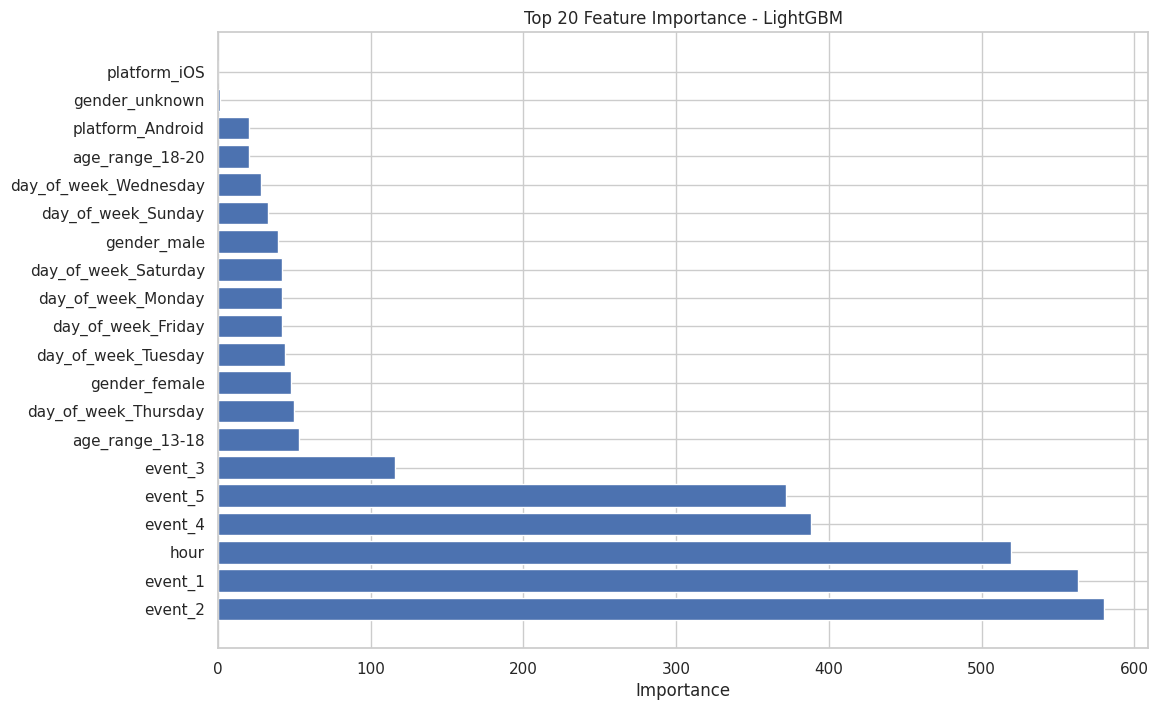

In [45]:
# Obtener la importancia de las variables
lgb_feature_importance = lgb_model.feature_importances_
feature_names = X_train.columns

# Crear un DataFrame para visualizar los resultados
lgb_importance_df = pd.DataFrame({'Variable': feature_names, 'Importance': lgb_feature_importance})
lgb_importance_df = lgb_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar el top 20 de variables importantes
top_20_lgb = lgb_importance_df.head(20)
print(top_20_lgb)

# Graficar el top 20 de variables importantes
plt.figure(figsize=(12, 8))
plt.barh(top_20_lgb['Variable'], top_20_lgb['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance - LightGBM')
plt.show()

### **Curvas ROC**

---


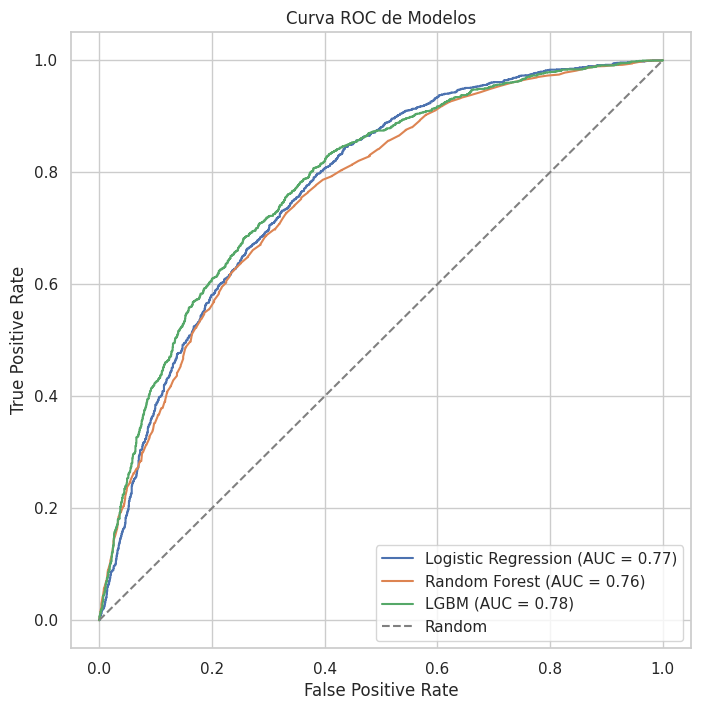

In [57]:
# Probabilidades de predicción
y_prob_lgbm = lgb_model.predict_proba(X_test)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]


# Calcular la tasa de verdaderos positivos (TPR), la tasa de falsos positivos (FPR) y el umbral
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_prob_lgbm)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logistic)


# Calcular el área bajo la curva ROC (AUC)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc = auc(fpr, tpr)


# Graficar la curva ROC
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LGBM (AUC = {roc_auc_lgbm:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC de Modelos')
plt.legend()

plt.show()
